# Принятие решений в бизнесе

__КОНТЕКСТ ПРОЕКТА:__  
Как аналитику крупного интернет-магазина - необходимо приоритизировать гипотезы для увеличения выручки, подготовленные вместе с отделом маркетинга.
Затем нужно запустить A/B-тест и проанализировать его результаты. 

__ЦЕЛИ И ЗАДАЧИ ИССЛЕДОВАНИЯ:__  
1. Проанализировать гипотезы
    - приоритизировать гипотезы с помощью фреймворка ICE
    - приоритизировать гипотезы с помощью фреймворка RICE
    - сравнить и пояснить результаты
2. Проанализировать результаты А/В тестирования
    - построить графики куиулятивной выручки, среднего чека и количества заказа по группам
    - построить график относительного изменения кумулятивного среднего чека группы В относительно группы А
    - построить точечные графики количества и стоимости заказов
    - рассчитать 95-й и 99-й перцентили количества и стоимости заказов
    - посчитать статистические значимости различий в среднем чеке и в среднем количестве заказов по сырым и по очищенным данным
    - принять решение по результатам тестирования

__ИСХОДНЫЕ ДАННЫЕ:__  

__Структура hypothesis.csv:__
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

__Структура orders.csv:__
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ. 

__Структура visitors.csv:__
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

__ПЛАН ПРОЕКТА:__
1. Изучить исходные данные.
2. Сделать необходимую предобработку.
3. Проанализровать гипотезы с помощью фреймворков ICE и RICE.
4. Построить необходимые графики по группам.
5. Рассчитать перцентили.
6. Посчитать статистические значимости по сырым и очищенным данным.
7. Принять решение относительно А/В тестирования (остановить или продолжить.
8. Написать общие выводы по результатам работы.

## Загрузка и настройка библиотек

In [1]:
# импорт и настройка библиотек
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings

plt.rcParams["figure.figsize"] = (12,6)
# сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# сброс предупреждений
warnings.filterwarnings('ignore')
# настройка полного отображения в ячейках
pd.set_option('max_colwidth', -1)
# настройка размера шрифта для графиков
plt.rcParams.update({'font.size': 15})

Для загрузки и первичного знакомства с данным создадим функции.

In [2]:
# создание функции
def def_info(df, rc=1, d=1, i=1, c=1, s=1):
    
    # описание функции и фрагмент для вывода: print(def_info.__doc__)
    """
    Эта функция выводит информацию о датафрейме:
    - количество строк и столбцов (в том числе пустых)
    - информация о дубликатах
    - сводная информация (аналог info)
    - названия столбцов
    - пример(ы) строк(и) датафрейма (можно указать количество)
    
    Принимает на вход:
    - `df` - датафрейм
    - `rc` - определяет вывод информации о количестве строк и столбцов (1 или 0)
    - `d` - определяет вывод информации о дубликатах (1 или 0)
    - `i` - определяет вывод сводной информации (1 или 0)
    - `c` - определяет вывод информации о названиях столбцов (1 или 0)
    - `s` - определяет вывод примера строки (значения больше 0 выводят указанное количество строк)
    
    Если указать только датафрейм, будет выведено всё.

    """
    
# получение и вывод информации о количестве строк и столбцов
    if rc == 1:
        empty_rows = (df.isna().all(axis=1)).sum()
        empty_rows_per = (df.isna().all(axis=1)).mean()
        empty_cols = (df.isna().all(axis=0)).sum()
        empty_cols_per = (df.isna().all(axis=0)).mean()
        print(f"- количество строк: {df.shape[0]}, \
              полностью пустых - {empty_rows} ({empty_rows_per:.0%})")
        print(f"- количество столбцов: {df.shape[1]}, \
              полностью пустых - {empty_cols} ({empty_cols_per:.0%})")
    
# создание таблицы для вывода сводной информации (аналог info(),
# но с указанием количества и доли пропусков для каждого столбца)    
    if i == 1:
        data_info = df.notnull().sum().to_frame(name='данные')
        data_info['пропуски'] = df.isnull().sum()
        data_info['% пропусков'] = round((df.isnull().sum() / len(df)), 2)
        data_info['тип данных'] = df.dtypes

# вывод таблицы с цветовой индикацией количества данных и пропусков
        display(data_info.style
            .format({'% пропусков': '{:.0%}'})
            .set_caption('сводная информация')
            .bar(subset=['данные'], color='lightgreen')
            .applymap(lambda x: 'background-color: peachpuff' if x > 0 else '' if x == 0 else '',
                      subset=['пропуски'])
            .bar(subset=['% пропусков'], color='coral')
            .set_table_styles([{'selector': 'caption', 
                                'props': [('color', 'coral'), ('font-size', '14px')]
                               }])
           )

# получение и вывод информации о количестве полных дубликатов
    if d == 1:
        duplicates = df.duplicated()
        num_duplicates = duplicates.sum()
        if num_duplicates == 0:
            print('Полных дубликатов нет')
        else:
            print('\033[1m\033[38;5;209m\nдубликаты\033[0m')    
            print('Количество полных дубликатов:', num_duplicates)
            
# вывод названий столбцов
    if c == 1:
        print('\033[1m\033[38;5;209m\nстолбцы\033[0m')
        print(df.columns.tolist())
        
# вывод нескольких строк для примера (можно указать количество)
    if s > 0:
        print('\033[1m\033[38;5;209m\nпример строк(и)\033[0m')
        display(df.sample(s))

In [3]:
# создание функции
def def_load_data(df_name, file_name, file_type, path=None, name=None, sep=None, sheet_name=0, header=0):

    # описание функции и фрагмент для вывода: print(def_load_data.__doc__)
    """
    Эта функция загружает данные из файла (csv или excel) и преобразует их в датафрейм для работы.
    Затем выводит основную информацию по файлу с помощью функции def_info
    Принимает на вход:
    - `df_name` - название создаваемого датафрейма
    - `file_name` - название загружаемого файла
    - `file_type` - тип загружаемого файла
    - `path` - путь к файлу (если файл находится в другой директории)
    - `name` - название таблицы для читателя, поясняющее содержимое файла
    - `sep` - разделитель для csv файла
    - `sheet_name` - имя листа в excel файле
    - `header` - номер строки, которую нужно использовать в качестве заголовка таблицы
    Обязательными являются только первые 3 параметра, остальные используются при необходимости.

    """
    
    # вывод информации об источнике
    print(
        '\033[1m\033[38;5;209mИСТОЧНИК\n{} - {}\033[0m'.format(file_name, name))
    
    # загрузка из источника определённого типа в датафрейм       
    if file_type == 'xls' or file_type == 'xlsx':
        try:
            df = pd.read_excel(path, sheet_name=sheet_name, header=header)
        except:
            df = pd.read_excel(file_name, sheet_name=sheet_name, header=header)
    elif file_type == 'csv':
        try:
            df = pd.read_csv(path, sep=sep)
        except:
            df = pd.read_csv(file_name, sep=sep)
    else:
        print('Тип файла не распознан')
        return
    globals()[df_name] = df
        
    # вывод информации о созданном датафрейме с помощью функции
    def_info(df, i=1, s=1, d=1, c=1)

## Загрузка, обзор данных и предобработка

С помощью функции загрузим все таблицы.

In [4]:
# загрузка данных с помощью функции
def_load_data('df_hypothesis', 'hypothesis.csv', 'csv',
              path='/datasets/hypothesis.csv',
              name='гипотезы')

ИСТОЧНИК
hypothesis.csv - гипотезы
- количество строк: 9,               полностью пустых - 0 (0%)
- количество столбцов: 5,               полностью пустых - 0 (0%)


,данные,пропуски,% пропусков,тип данных
Hypothesis,9,0,0%,object
Reach,9,0,0%,int64
Impact,9,0,0%,int64
Confidence,9,0,0%,int64
Efforts,9,0,0%,int64


Полных дубликатов нет

столбцы
['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts']

пример строк(и)


,Hypothesis,Reach,Impact,Confidence,Efforts
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10


In [5]:
# загрузка данных с помощью функции
def_load_data('df_orders', 'orders.csv', 'csv',
              path='/datasets/orders.csv',
              name='заказы')

ИСТОЧНИК
orders.csv - заказы
- количество строк: 1197,               полностью пустых - 0 (0%)
- количество столбцов: 5,               полностью пустых - 0 (0%)


,данные,пропуски,% пропусков,тип данных
transactionId,1197,0,0%,int64
visitorId,1197,0,0%,int64
date,1197,0,0%,object
revenue,1197,0,0%,int64
group,1197,0,0%,object


Полных дубликатов нет

столбцы
['transactionId', 'visitorId', 'date', 'revenue', 'group']

пример строк(и)


,transactionId,visitorId,date,revenue,group
41,2594268419,237748145,2019-08-15,1090,A


In [6]:
# загрузка данных с помощью функции
def_load_data('df_visitors', 'visitors.csv', 'csv',
              path='/datasets/visitors.csv',
              name='пользователи')

ИСТОЧНИК
visitors.csv - пользователи
- количество строк: 62,               полностью пустых - 0 (0%)
- количество столбцов: 3,               полностью пустых - 0 (0%)


,данные,пропуски,% пропусков,тип данных
date,62,0,0%,object
group,62,0,0%,object
visitors,62,0,0%,int64


Полных дубликатов нет

столбцы
['date', 'group', 'visitors']

пример строк(и)


,date,group,visitors
61,2019-08-31,B,718


Пропусков и полных дубликатов нет, но необходимо поменять названия столбцов - привести их к "хорошему" стилю.

In [7]:
# приведение названий столбцов к нижнему регистру
df_hypothesis.columns = df_hypothesis.columns.str.lower()

# приведение названий столбцов к змеиному стилю
df_orders = df_orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})

In [8]:
# проверка
print(df_hypothesis.columns)
print(df_orders.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')
Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')


Столбец с датой имеет тип `object` - поменяем на формат даты.

In [9]:
# изменение типа данных
df_orders['date'] = pd.to_datetime(df_orders['date'])
df_visitors['date'] = pd.to_datetime(df_visitors['date'])

# проверка
print('Новый тип данных в df_orders `date`:', df_orders['date'].dtype)
print('Новый тип данных в df_visitors `date`:', df_visitors['date'].dtype)

Новый тип данных в df_orders `date`: datetime64[ns]
Новый тип данных в df_visitors `date`: datetime64[ns]


Посмотрим, какой диапазон данных представлен в таблицах (узнаем длительность теста).

In [10]:
# определение нужных дат и вывод информации
print('Диапазон дат датасета df_orders:', 
      df_orders['date'].min().strftime('%d %B %Y'),
      '-', df_orders['date'].max().strftime('%d %B %Y'))

# определение нужных дат и вывод информации
print('Диапазон дат датасета df_visitors:', 
      df_visitors['date'].min().strftime('%d %B %Y'),
      '-', df_visitors['date'].max().strftime('%d %B %Y'))

Диапазон дат датасета df_orders: 01 August 2019 - 31 August 2019
Диапазон дат датасета df_visitors: 01 August 2019 - 31 August 2019


Теперь выведем группы АВ-теста.

In [11]:
# вывод информации
print('Группы АВ-теста (таблица df_orders):', ', '.join(sorted(df_orders['group'].unique())))
print('Группы АВ-теста (таблица df_visitors):', ', '.join(sorted(df_visitors['group'].unique())))

Группы АВ-теста (таблица df_orders): A, B
Группы АВ-теста (таблица df_visitors): A, B


Определим, сколько пользователей в каждой группе и сколько в каждой группе было сделано заказов.

In [12]:
# создание переменных
unique_users = df_orders['visitor_id'].nunique()
unique_users_A = df_orders.query('group == "A"')['visitor_id'].nunique()
unique_users_B = df_orders.query('group == "B"')['visitor_id'].nunique()
visitors_A = df_visitors[df_visitors['group'] == 'A']['visitors'].sum()
visitors_B = df_visitors[df_visitors['group'] == 'B']['visitors'].sum()
per_unique_users_A = round(unique_users_A / unique_users * 100)
per_unique_users_B = round(unique_users_B / unique_users * 100)

# вывод информации
print(f"Количество уникальных пользователей ({unique_users}):")

print(f"- группа A: {unique_users_A} ({per_unique_users_A}%)")

print(f"- группа B: {unique_users_B} ({per_unique_users_B}%)")

print('\nКоличество заказов:')
print('- группа A:',
      df_orders.query('group == "A"')['visitor_id'].count())

print('- группа B:',
      df_orders.query('group == "B"')['visitor_id'].count())

Количество уникальных пользователей (1031):
- группа A: 503 (49%)
- группа B: 586 (57%)

Количество заказов:
- группа A: 557
- группа B: 640


Посмотрим, есть ли пользователи, которые попали в обе группы.

In [13]:
# вычисление значений
unique_counts = df_orders.groupby('visitor_id')[['group']].nunique(dropna=False)
multi_unique = unique_counts.query('group > 1')

# вывод количества пользователей, попавших в обе группы
if multi_unique.empty:
    print('Нет пользователей, которые попали в обе группы теста.')
else:
    print(f'Есть пользователи ({len(multi_unique)} чел.), которые попали в обе группы теста.')
    
# вывод доли пользователей, попавших в обе группы

multi_group_users_per = round(len(multi_unique) / unique_users * 100)
print(f"Это {multi_group_users_per}% от общего числа пользователей.")

Есть пользователи (58 чел.), которые попали в обе группы теста.
Это 6% от общего числа пользователей.


Довольно немного. Оставим как есть.

<div style="border:solid green 2px; padding: 20px">    
Данные успешно загружены и проверены, проведена небольшая стилистическая предобработка.
<br>Диапазон дат теста соответствует заявленному: с 1 по 31 августа 2019 года.
<br>Определено количество пользователей в каждой группе (группа A: 503 (49%), группа B: 586 (57%)) и количество заказов (группа A: 557, группа B: 640). Найдены пользователи, попавшие в обе группы (58 человек - 6% от общего количества).
</div>

## Приоритизация гипотез

Отдел маркетинга подготовил список из 9-ти гипотез, параметры которых оценены по шкале от 0 до 10.  
Посмотрим на таблицу с гипотезами - так как она небольшая, выведем её полностью.

In [14]:
# вывод таблицы
df_hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Все нужные данные в таблице есть - расситаем приоритетность гипотез фреймворка ICE.

In [15]:
# добавление нового столбца с расчетом фреймворка ICE
df_hypothesis['ice'] = df_hypothesis['impact'] * df_hypothesis['confidence'] / df_hypothesis['efforts']

# вывод на экран названия гипотезы и значения ICE, отсортированные по убыванию ICE
# и округление значений до 2 знаков после запятой
round(df_hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False), 2)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


По методу ICE 3 наиболее приоритетные гипотезы 8, 0 и 7 со значениями ICE 16, 13 и 11 соответственно.  
Лидирует гипотеза 8: _"Запустить акцию, дающую скидку на товар в день рождения"_.

Теперь сделаем аналогичный расчет фреймворка RICE.

In [16]:
# добавление нового столбца с расчетом фреймворка RICE
df_hypothesis['rice'] = (
    df_hypothesis['reach'] * df_hypothesis['impact'] 
    * df_hypothesis['confidence'] / df_hypothesis['efforts']
)


# вывод на экран названия гипотезы и значения RICE, отсортированные по убыванию ICE
# и округление значений до 2 знаков после запятой
round(df_hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False), 2)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Лидирующая в методе ICE гипотеза 8 уходит на 5 место. Это вполне объяснимо: в методе RICE добавляется параметр reach, учитывающий количество пользователей, которых затронет изменение. А акция на день рождения охватывает не так много пользователей.  
В RICE первое место занимает гипотеза 7: _"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"_  
  
Гипотеза 0 удерживает хорошие позиции как в случае с ICE (2 место), так и при подсчете фреймфорка RICE (3 место). Так что эту гипотезу вполне можно рассмотреть для дальнейших тестов.

<div style="border:solid green 2px; padding: 20px">    
Согласно обоим методам, можно выделить две лидирующие гипотезы:
<br>- гипотеза 7: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",
<br>- гипотеза 0: "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".
</div>

## Анализ A/B-теста

Для анализа AB-теста создадим сводную таблицу по группам, отразив все изменения кумулятивно.

In [17]:
# создание массива уникальных пар значений дат и групп теста
dates_grouped = df_orders[['date', 'group']].drop_duplicates()

# получение агрегированных кумулятивных по дням данных о заказах 
orders_grouped = dates_grouped.apply(
    lambda x: df_orders[
        np.logical_and(
            df_orders['date'] <= x['date'], df_orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1
).sort_values(by=['date', 'group'])

In [18]:
# получение агрегированных кумулятивных по дням данных о посетителях интернет-магазина 
visitors_grouped = dates_grouped.apply(
    lambda x: df_visitors[
        np.logical_and(
            df_visitors['date'] <= x['date'], df_visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', 
            'group': 'max', 
            'visitors': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [19]:
# объединение данных
cumulative_data = orders_grouped.merge(
    visitors_grouped, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

# переименование столбцов
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# вывод первых 4 дней в двух группах
display(cumulative_data.head(8))


# проверка дат
print('Диапазон дат датасета cumulative_data:', 
      cumulative_data['date'].min().strftime('%d %B %Y'),
      '-', cumulative_data['date'].max().strftime('%d %B %Y'))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803
6,2019-08-04,A,84,77,425699,2562
7,2019-08-04,B,78,75,489567,2573


Диапазон дат датасета cumulative_data: 01 August 2019 - 31 August 2019


### График кумулятивной выручки по группам

Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

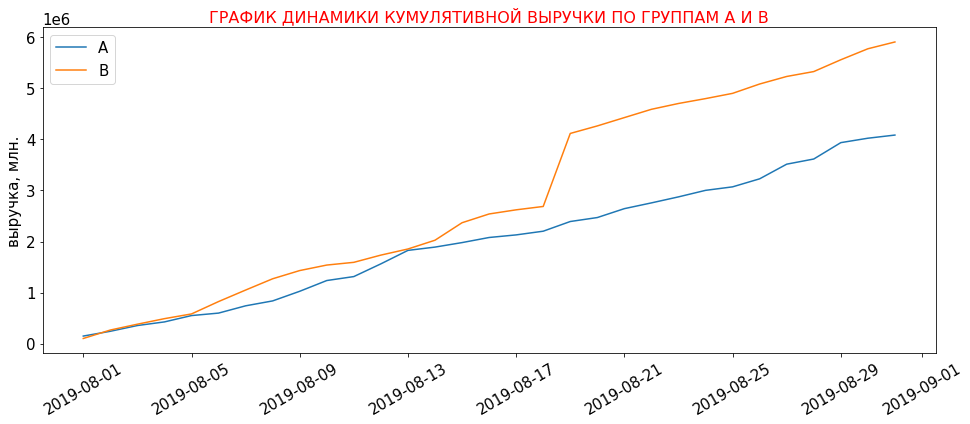

In [20]:
# создание датафрейма с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data.query('group=="A"')[['date','revenue', 'orders']]

# создание датафрейма с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data.query('group=="B"')[['date','revenue', 'orders']]

# построение графика
plt.figure(figsize=(16, 6)) 
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('ГРАФИК ДИНАМИКИ КУМУЛЯТИВНОЙ ВЫРУЧКИ ПО ГРУППАМ А И В', color='red', fontsize=16) 
plt.ylabel("выручка, млн.")
plt.xticks(rotation=30)
plt.legend();

<div style="border:solid green 2px; padding: 20px">    
У обеих групп стабильный рост выручки в течение всего теста. В первые дни обе группы идут примерно одинаково, но с в районе 18 августа заметен резкий скачок роста в группе В. После чего в обеих группах продолжается параллельный рост, но разница между двумя группами уже существенная.
<br>Такой резкий скачок для группы В может быть показателем или слишком дорогих заказов или неожиданного роста количества заказов.
</div>

### График кумулятивного среднего чека по группам

Построим __графики среднего чека по группам__ — разделим кумулятивную выручку на кумулятивное число заказов:

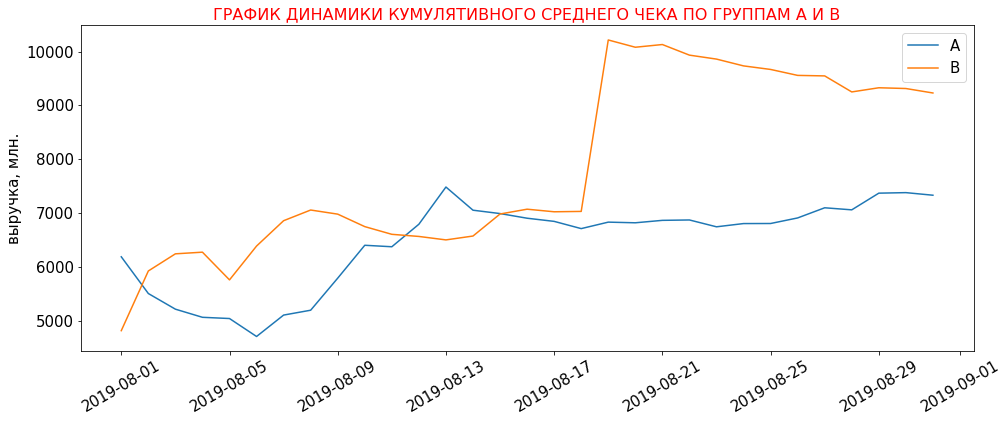

In [21]:
# построение графика
plt.figure(figsize=(16, 6)) 
plt.plot(cumulative_revenue_a['date'], 
         cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'],
         label='A')

plt.plot(cumulative_revenue_b['date'], 
         cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], 
         label='B')

plt.title('ГРАФИК ДИНАМИКИ КУМУЛЯТИВНОГО СРЕДНЕГО ЧЕКА ПО ГРУППАМ А И В', color='red', fontsize=16) 
plt.ylabel("выручка, млн.")
plt.xticks(rotation=30)
plt.legend();

<div style="border:solid green 2px; padding: 20px">
На графике для группы В видим резкий скачок среднего чека (в ту же дату, что и на предыдущем графике). После чего в этой группе идёт постепенное снижение (но до конца теста средний чек группы В остаётся выше среднего чека группа А).
<br>В группе А после максимального значения 13 августа довольно стабильный средний чек.
</div>

### График относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

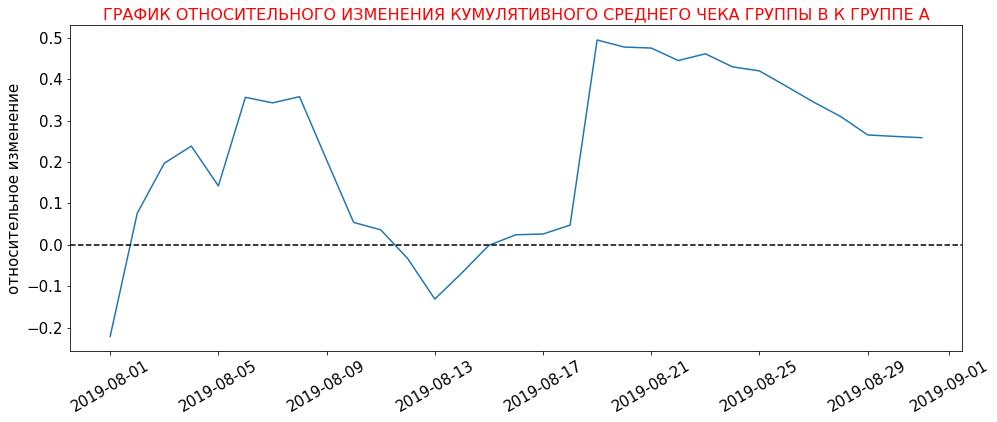

In [22]:
# создание датафрейма
cumulative_revenue_ab = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

# построение графика
plt.figure(figsize=(16, 6)) 
plt.plot(cumulative_revenue_ab['date'], 
         (
             cumulative_revenue_ab['revenue_b']/cumulative_revenue_ab['orders_b']
         )/
         (
             cumulative_revenue_ab['revenue_a']/cumulative_revenue_ab['orders_a']
         )-1
        )

plt.axhline(y=0, color='black', linestyle='--')
plt.title('ГРАФИК ОТНОСИТЕЛЬНОГО ИЗМЕНЕНИЯ КУМУЛЯТИВНОГО СРЕДНЕГО ЧЕКА ГРУППЫ В К ГРУППЕ А',
          color='red', fontsize=16) 
plt.ylabel("относительное изменение")
plt.xticks(rotation=30);

<div style="border:solid green 2px; padding: 20px">
Практически всё время кумулятивный средний чек группы В преобладает над чеком группы А. Если только один провал 13 августа (когда группа А была выше группы В по среднему чеку).
<br>Также на графике хорошо видны пики. Особенно заметен скачок 18 августа, который мы ранее видели на других графиках.
</div>

### График кумулятивного среднего количества заказов на посетителя по группам

Построим график кумулятивного среднего количества заказов на посетителя по группам

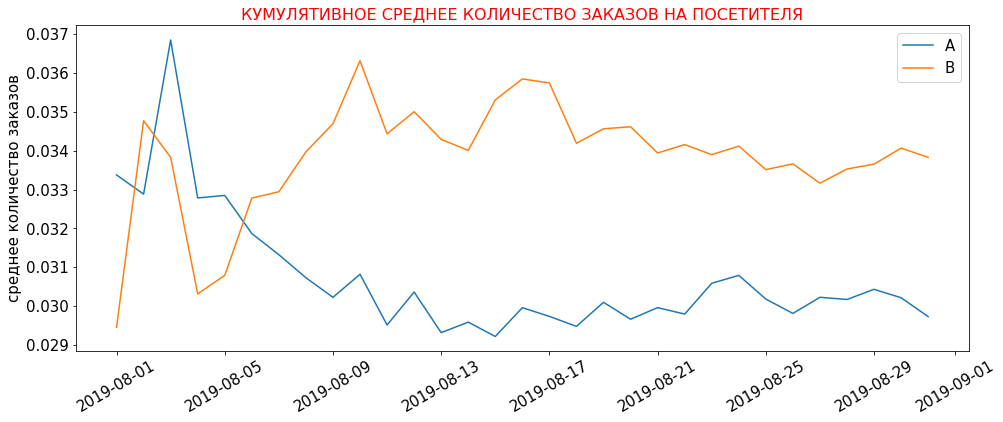

In [23]:
# создание нового столбца
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# создание выборки для группы А
cumulative_data_a = cumulative_data.query('group == "A"')

# оздание выборки для группы В
cumulative_data_b = cumulative_data.query('group == "B"')

# построение графика
plt.figure(figsize=(16, 6)) 
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.title('КУМУЛЯТИВНОЕ СРЕДНЕЕ КОЛИЧЕСТВО ЗАКАЗОВ НА ПОСЕТИТЕЛЯ',
          color='red', fontsize=16) 
plt.ylabel("среднее количество заказов")
plt.xticks(rotation=30);

<div style="border:solid green 2px; padding: 20px">
В начале теста видны сильные колебания в обеих группах и обе группы показывают симметричный рисунок, но приблизительно с 6 августа группа В уходит вверх (показывая более высокие показатели), а группа А уходит вниз. С этого времени среднее количество заказов на посетителя группы В выше среднего количества заказов на посетителя группы А.
</div>

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

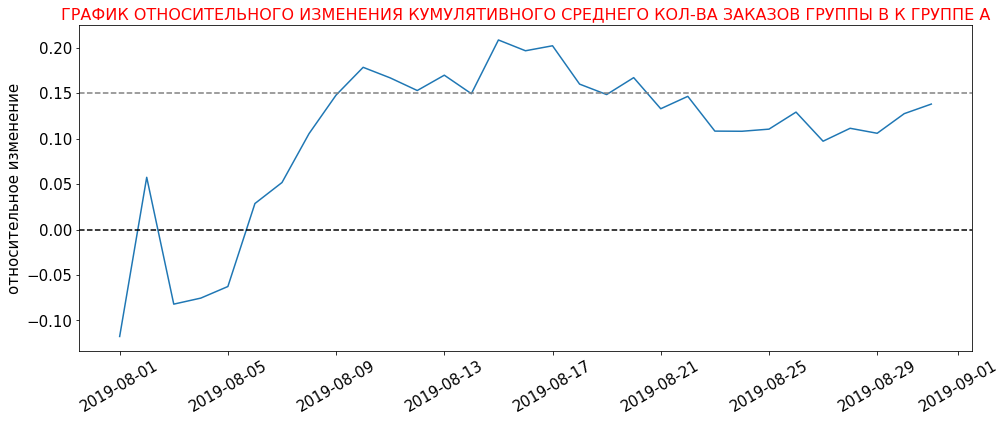

In [24]:
# создание датафрейма
cumulative_conversions_ab = (
    cumulative_data_a[['date','conversion']]
    .merge(
        cumulative_data_b[['date','conversion']], 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['_a', '_b']
    )
)

# построение графика
plt.figure(figsize=(16, 6)) 
plt.plot(
    cumulative_conversions_ab['date'], 
    cumulative_conversions_ab['conversion_b']/
    cumulative_conversions_ab['conversion_a']-1
)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('ГРАФИК ОТНОСИТЕЛЬНОГО ИЗМЕНЕНИЯ КУМУЛЯТИВНОГО СРЕДНЕГО КОЛ-ВА ЗАКАЗОВ ГРУППЫ В К ГРУППЕ А',
          color='red', fontsize=16) 
plt.ylabel("относительное изменение")
plt.xticks(rotation=30);

<div style="border:solid green 2px; padding: 20px">
В самом начале теста относительное изменение среднего числа заказов было ниже 0, то есть группа А давала лучше результат, чем группа В.
<br>Затем, начиная с 5 августа, у группы В относительное изменение среднего числа заказов всегда было выше 0 (что означает более высокие показатели относительно группы А). В районе 17 числа можно наблюдать небольшой спад практически до конца теста. В конце снова наблюдается рост.
</div>

###  Точечный график количества заказов по пользователям

Построим точечный график количества заказов по пользователям.

In [25]:
# создание датафрейма
orders_by_users = (
    df_orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns =  ['visitor_id', 'orders']

orders_by_users['orders'].value_counts()

1     937
2     64 
3     17 
5     6  
4     3  
11    2  
8     1  
9     1  
Name: orders, dtype: int64

Типовое количество заказов для пользователей - 1. Но есть те, кто сделал больше 1 заказа (таких пользователей немного, но эти данные могут исказить результаты А\В теста).

Посмотрим как распределены в целом количества заказов.

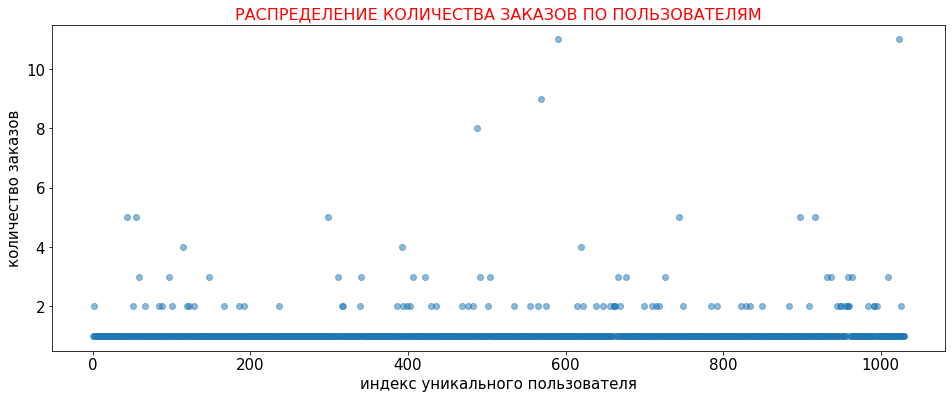

In [26]:
# построение графика
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(16, 6)) 
plt.scatter(x_values, orders_by_users['orders'], alpha=0.5)
plt.title('РАСПРЕДЕЛЕНИЕ КОЛИЧЕСТВА ЗАКАЗОВ ПО ПОЛЬЗОВАТЕЛЯМ',
          color='red', fontsize=16)
plt.xlabel('индекс уникального пользователя')
plt.ylabel('количество заказов'); 

<div style="border:solid green 2px; padding: 20px">
Большинство пользователей совершили 1 заказ. Всё, что больше 3 можно отнести к исключениям.
</div>

###  95-й и 99-й перцентили количества заказов на пользователя

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей.

In [27]:
# вывод информации
print('95 перцентиль количества заказов:',
      ''.join(map(str, np.percentile(orders_by_users['orders'], [95]))))
print('98 перцентиль количества заказов:',
      ''.join(map(str, np.percentile(orders_by_users['orders'], [98]))))
print('99 перцентиль количества заказов:',
      ''.join(map(str, np.percentile(orders_by_users['orders'], [99]))))

95 перцентиль количества заказов: 2.0
98 перцентиль количества заказов: 3.0
99 перцентиль количества заказов: 4.0


<div style="border:solid green 2px; padding: 20px">
Не более 5% пользователей совершили более 2 заказов. И менее 1% совершают более 4 заказов.
    
<br>В качестве аномальных данных обычно принимают от 1 до 5% значений в зависимости от целей. В нашем случае для анализа результатов А\В теста, можно взять промежуточный вариант - 3 заказа (98 процентиль). Т.е. от 1 до 5 % пользователей совершают более 3 заказов. Их будем исключать из дальнейших исследований.
</div>

###  Точечный график стоимости заказов по пользователям

Построим точечный график стоимости заказов по пользователям.

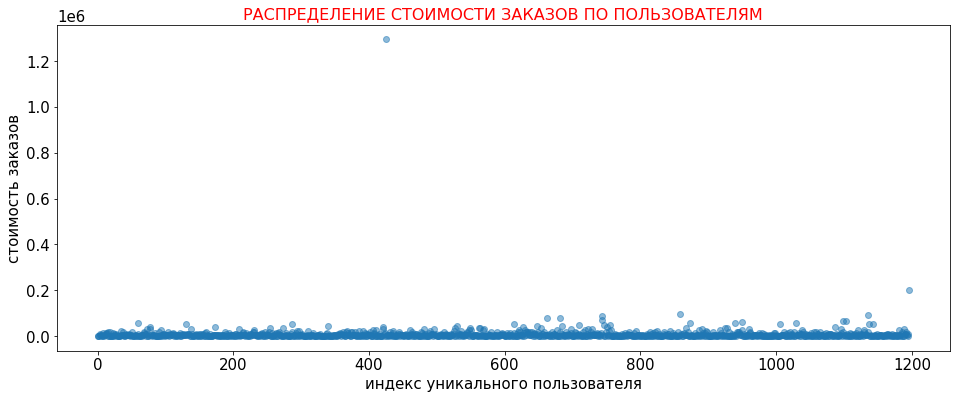

In [28]:
# построение графика
x_values = pd.Series(range(0,len(df_orders['revenue'])))

plt.figure(figsize=(16, 6)) 
plt.scatter(x_values, df_orders['revenue'], alpha=0.5)
plt.title('РАСПРЕДЕЛЕНИЕ СТОИМОСТИ ЗАКАЗОВ ПО ПОЛЬЗОВАТЕЛЯМ',
          color='red', fontsize=16)
plt.xlabel('индекс уникального пользователя')
plt.ylabel('стоимость заказов'); 

<div style="border:solid green 2px; padding: 20px">
На графике хорошо видны два сильно выбивающихся по стоимости заказа и несколько "всплесков", которые гораздо ближе к типовым по стоимости заказам.
<br>Исключим два самых крупных заказа, чтобы лучше рассмотреть разброс по остальным заказам.
</div>

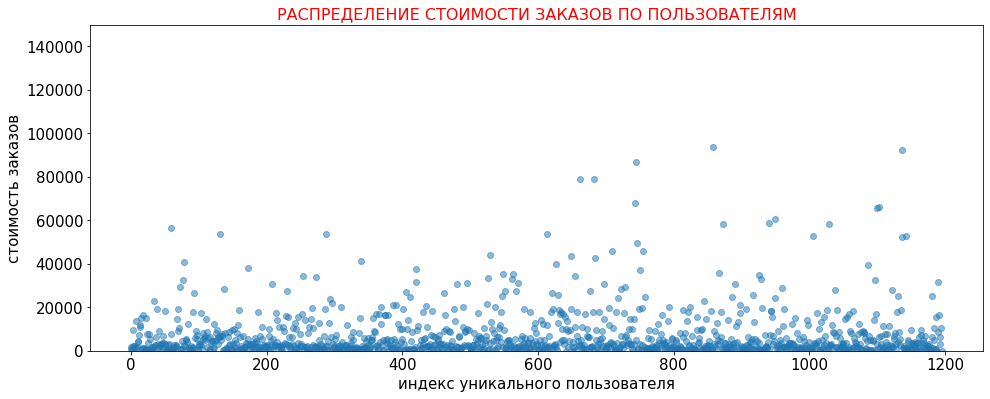

In [29]:
# построение графика
plt.figure(figsize=(16, 6)) 
plt.ylim(0, 150000)
plt.scatter(x_values, df_orders['revenue'], alpha=0.5)
plt.title('РАСПРЕДЕЛЕНИЕ СТОИМОСТИ ЗАКАЗОВ ПО ПОЛЬЗОВАТЕЛЯМ',
          color='red', fontsize=16)
plt.xlabel('индекс уникального пользователя')
plt.ylabel('стоимость заказов'); 

<div style="border:solid green 2px; padding: 20px">
Большинство пользователей делают заказы на сумму до 20000 рублей. Но даже здесь видны выбросы с дорогими заказами. Можно предположить, что эти заказы были сделали в районе 18 августа (когда как раз был резкий скачок по среднему чеку).
</div>

###  95-й и 99-й перцентили стоимости заказов

Чтобы узнать точные цифры границы стоимостей заказов посчитаем перцентили на 95 и 99%.

In [30]:
# вывод информации
print('95 перцентиль стоимости заказов:',
      ''.join(map(str, np.percentile(df_orders['revenue'], [95]))))
print('99 перцентиль стоимости заказов:',
      ''.join(map(str, np.percentile(df_orders['revenue'], [99]))))

95 перцентиль стоимости заказов: 28000.000000000004
99 перцентиль стоимости заказов: 58233.19999999999


<div style="border:solid green 2px; padding: 20px">
Менее 5% пользователей совершают покупки на сумму более 28000 рублей. И менее 1% посетителей - на сумму более 58000 рублей.
    
<br>В качестве выбросов (аномальных значений) можно считать заказы стоимостью не более 4400 рублей (по 98 процентилю).
</div>

## Анализ статистической значимости

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость на сырых данных (не удаляя аномалии).

Сформулируем гипотезы: 
- __H0 (нулевая):__ Между группами __нет статистически значимых различий__ в среднем среднем количестве заказов на посетителя.
- __H1 (альтернативная):__ Между группами __есть статистически значимые различия__ в среднем количестве заказов на посетителя.

Значение alpha - 0.05.

Для исследования будем использовать непараметрический метод - критерий Манна-Уитни. Этот метод хорошо применим для наших данных поскольку в них присутствуют выбросы, которые могут исказить результаты. А также поскольку для непараметрического метода не требуется преположения нормальности распределния.

Для каждой группы создадим таблички с пользователями, сделавшими хотя бы один заказ и укажем для них число совершённых заказов.

In [31]:
# создание датафреймов и переименование столбцов
order_by_users_A = (
    df_orders.query('group == "A"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
order_by_users_A.columns = ['user_id', 'orders']

order_by_users_B = (
    df_orders.query('group == "B"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
order_by_users_B.columns = ['user_id', 'orders'] 

Подготовим данные для проверки критерием Манна-Уитни.

In [32]:
# подготовка данных для каждой группы 
sample_A = pd.concat([order_by_users_A['orders'],pd.Series(0, index=np.arange(visitors_A\
                    - len(order_by_users_A['orders'])), name='orders')],axis=0)

sample_B = pd.concat([order_by_users_B['orders'],pd.Series(0, index=np.arange(visitors_B \
                    - len(order_by_users_B['orders'])), name='orders')],axis=0) 

Применим критерий Манна-Уитни и выведем на экран p_value, округленное до 3 знаков после запятой

In [33]:
# применение критерия Манна-Уитни и вывод информации на экран
print('Значение p_value',"{0:.3f}".format(stats.mannwhitneyu(sample_A, sample_B)[1]))

print('Относительный прирост группы В:', "{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

Значение p_value 0.017
Относительный прирост группы В: 0.138


<div style="border:solid green 2px; padding: 20px">
Статистическая значимость меньше 0.05 - значит, отвергаем нулевую гипотезу. Соответственно, между группами есть различия в среднем количестве заказов.
    
<br>Относительный прирост среднего числа заказов на посетителя группы В положительный и равен 13.8%.
Это означает, что в группе В на 13% большее количество заказов на посетителя, относительно группы А.
</div>

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Посчитаем аналогично статистическую значимость, но по различию среднего чека между группами А и В по сырым данным.

Сформулируем гипотезы:
- __H0 (нулевая):__ Между группами __нет статистически значимых различий__ в среднем среднем чеке.
- __H1 (альтернативная):__ Между группами __есть статистически значимые различия__ в среднем чеке.

Значение alpha - 0.05.

Метод исследования - критерий Манна-Уитни. 

In [34]:
# применение критерия Манна-Уитни
print('Значение p_value',
      '{0:.3f}'.format(stats.mannwhitneyu(df_orders[df_orders['group']=='A']['revenue'], \
                                          df_orders.query('group == "B"')['revenue'])[1]))
print('Относительный прирост группы В',
      '{0:.3f}'.format(df_orders.query('group == "B"')\
                       ['revenue'].mean()/df_orders.query('group == "A"')['revenue'].mean()-1)) 

Значение p_value 0.729
Относительный прирост группы В 0.259


<div style="border:solid green 2px; padding: 20px">
Статистическая значимость довольно высокая (72%) - значит, нулевую гипотезу отвергнуть не можем. С вероятностью в 72% различий между группами в среднем чеке нет.
    
<br>Относительный прирост среднего чека группы B относительно группы А составляет 25.9%.
</div>

 ### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Теперь посчитаем всё то же, но по очищенным данным.  
Примем за аномальных пользователей тех, кто делает больше 3 заказов и у кого выручка с заказа более 40000.
Подсчет этих показателей мы произвели с разделе перцентилей.

Выделим аномальных пользователей.

In [35]:
# создание среза аномальных пользователей по количеству заказов
users_with_many_orders = pd.concat(
    [order_by_users_A[order_by_users_A['orders'] > np.percentile(orders_by_users['orders'], 98)]['user_id'],
     order_by_users_B[order_by_users_B['orders'] > np.percentile(orders_by_users['orders'], 98)]['user_id'],
    ],axis=0,
)

# создание среза аномальных пользователей по стоимости заказов
users_with_expensive_rders = (
    df_orders[df_orders['revenue'] > np.percentile(df_orders['revenue'], 98)]['transaction_id'])

# объединение срезов
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_rders], axis=0)
    .drop_duplicates()
    .sort_values()
)

# вычисление доли аномальных пользователей
abnormal_share = abnormal_users.count() / pd.Series(df_orders['visitor_id'].unique()).count()

# вывод информации
print(f'Количество аномальных пользователей: {abnormal_users.shape[0]}') 
print('Относительное количество аномальных пользователей', "{0:.1%}".format(abnormal_share), '\n')

print(abnormal_users.head(5))

Количество аномальных пользователей: 33
Относительное количество аномальных пользователей 3.2% 

858     192721366
18      199603092
23      237748145
1099    316924019
1029    469609643
dtype: int64


Всего 33 аномальных пользователя (3.2%) - не так много от общего объёма.

Можно удалить эти выбросы.

In [36]:
# фильтрация данных для двух групп
filtered_sample_A = pd.concat(
    [
        order_by_users_A[
            np.logical_not(order_by_users_A['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_A - len(order_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

filtered_sample_B = pd.concat(
    [
        order_by_users_B[
            np.logical_not(order_by_users_B['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_B - len(order_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Посмотрим, что покажут очищенные данные по среднему количеству заказов на посетителя.  

Снова проверим гипотезы: 
- __H0 (нулевая):__ Между группами __нет статистически значимых различий__ в среднем среднем количестве заказов на посетителя.
- __H1 (альтернативная):__ Между группами __есть статистически значимые различия__ в среднем количестве заказов на посетителя.

Значение alpha - 0.05.

Для очищенных данных также будем использовать непараметрический метод - критерий Манна-Уитни.

In [37]:
# применение критерия Манна-Уитни
print('Значение p_value', '{0:.3f}'
      .format(stats.mannwhitneyu(filtered_sample_A, filtered_sample_B)[1]))
print(
    'Относительный прирост группы В', '{0:.3f}'
    .format(filtered_sample_B.mean()/filtered_sample_A.mean()-1)) 

Значение p_value 0.016
Относительный прирост группы В 0.147


<div style="border:solid green 2px; padding: 20px">
Незначительная разница с "сырыми" данными. 
<br>P_value также ниже 0.05. Ещё раз убеждаемся, что между группами есть отличия в среднем количестве заказов.
<br>Относительный прирост среднего чека группы B относительно группы А составляет 14.7%.
</div>

### Статистическая значимость различий в среднем чеке по «очищенным» данным

Аналогично применим критерий Манна-Уитни к очищенным данным по среднему чеку заказа между группами.

Проверим гипотезы:
- __H0 (нулевая):__ Между группами __нет статистически значимых различий__ в среднем среднем чеке.
- __H1 (альтернативная):__ Между группами __есть статистически значимые различия__ в среднем чеке.

Значение alpha - 0.05.

Метод исследования - критерий Манна-Уитни. 

In [38]:
# применение критерия Манна-Уитни
print('Значение p_value',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            df_orders[
                np.logical_and(
                    df_orders['group'] == 'A',
                    np.logical_not(df_orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            df_orders[
                np.logical_and(
                    df_orders['group'] == 'B',
                    np.logical_not(df_orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительный прирост группы В',
    "{0:.3f}".format(
        df_orders[
            np.logical_and(
                df_orders['group'] == 'B',
                np.logical_not(df_orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / df_orders[
            np.logical_and(
                df_orders['group'] == 'A',
                np.logical_not(df_orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 


Значение p_value 0.899
Относительный прирост группы В 0.238


<div style="border:solid green 2px; padding: 20px">
Здесь также нет принципиальных изменений. 
<br>P_value ещё увеличился и составляет почти 90%. Подтверждаем, что различий в среднем чеке нет.
<br>Относительный прирост среднего чека группы B относительно группы А составляет 23.8%.
</div>

## ВЫВОД

 <div style="border: solid green 4px; border-style: double; padding: 20px;">
    <b>ВЫВОДЫ ПО ПРОЕКТУ</b>
    
В рамках данного исследования были проанализированы гипотезы, подготовленные отделом маркетинга. И был проведён анализ А/В тестирования.

В нашем распоряжении были данные: <br>- список гипотез,<br>- данные о заказах,<br>- данные о пользователях по группам А/В тестирования.  

<b>ПРИОРИТИЗАЦИЯ ГИПОТЕЗ</b><br>
В результате анализа фреймворками ICE и RICE лидируют
<br>- гипотеза 7, показывая хорошие позиции и в ICE (3 место) и в RICE (1 место): <i>"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"</i>,
<br>- гипотеза 0, также показывая хорошие позиции и в ICE (2 место) и в RICE (3 место): <i>"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".</i>
<br>Также стоит отметить гипотезу 8, которая занимает первое место в ICE (в RICE только 5 место): <i>"Запустить акцию, дающую скидку на товар в день рождения".</i>
    

<b>АНАЛИЗ А/В тестирования</b><br>
На основе графиков хорошо видно, что:
<br>- кумулятивная выручка группы В выше
<br>- кумулятивный средний чек группы В выше
<br>- кумулятивное среднее количество заказов группы В выше
    
<br>Анализ статистической значимости различий показал, что:
<br>- есть различия в среднем количестве заказов между группами (результаты аналогичны и в "сырых" и в "очищенных" данных)
<br>- нет различий в среднем чеке между группами (результаты аналогичны и в "сырых" и в "очищенных" данных)

    
<b>РЕШЕНИЕ ОТНОСИТЕЛЬНО ПРОДОЛЖЕНИЕ А/В ТЕСТИРОВАНИЯ</b><br>
Исходя из имеющихся данных можно признать победу группы В и остановить тест. Спустя месяц теста очевидно, что группа В показывает лучшие результаты по всем параметрам.

    
</div>